In [73]:
import datetime
import importlib
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import yfinance as yf
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import misc
importlib.reload(misc)

<module 'misc' from '/Users/K/works/git/jm-xgb/misc.py'>

In [74]:
def create_clf():
    """
    LightGBM の分類器を作るヘルパー。
    ラベルは 0/1 の二値なので objective='binary'。
    """
    clf = LGBMClassifier(
        objective="binary",
        n_estimators=200,      # ツリー本数（必要なら増やす）
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,         # 制限なし（必要なら制限してもOK）
        subsample=0.8,        # 行サブサンプリング
        colsample_bytree=0.8, # 列サブサンプリング
        random_state=42,
        n_jobs=-1,
    )
    return clf

In [92]:
start_date = "2000-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

In [93]:
ticker = [
    "XLB", "XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY"
] 
df: pd.Series = yf.download(ticker, start=start_date, end=end_date)["Close"]
rets = np.log(df).diff().dropna()

[*********************100%***********************]  9 of 9 completed


In [94]:
def run(rets, start_idx, n_regimes, jump_penalty, freq):
    scaler = misc.Scaler()
    clipper = misc.Clipper(mul=3)
    model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=jump_penalty)
    clf = create_clf() #XGBClassifier()

    last_fit_date = None
    def should_fit(last_fit_date, current_date, freq):
        current = current_date.date()
        if last_fit_date is None:
            return True
        delta = current - last_fit_date
        return delta.days >= freq
    
    n = rets.shape[0]
    current_idx = start_idx
    end_idx = n - 1
    w = np.ones(n)
    while True:
        current_idx += 1
        obs = rets[:current_idx]
        X = misc.feature_engineer(obs)
        if should_fit(last_fit_date, obs.index[-1], freq):
            last_fit_date = obs.index[-1].date()
            X_processed = scaler.fit_transform(clipper.fit_transform(X))
            model.fit(X_processed)
            labels = misc.rearange_labels(model.labels, obs)
            y = pd.Series(labels).shift(-1)
            y_idx = y.dropna().index
            clf.fit(
                pd.DataFrame(X_processed, columns=X.columns).loc[y_idx], 
                y.loc[y_idx].astype(int)
            )
        else:
            X_processed = scaler.transform(clipper.transform(X))
            pred_labels, pred_probs = model.prediction(X_processed)
            labels = misc.rearange_labels(pred_labels, obs)

        w[current_idx] = clf.predict(
            pd.DataFrame(X_processed, columns=X.columns).iloc[[-1]]
        )
        if current_idx == end_idx:
            break

    return w

In [95]:
def select_lambda(window, n_regimes, current_lambda, lambda_grid, train_ratio):
    n = len(window)
    if n < 100:
        return current_lambda
    
    X = misc.feature_engineer(window)
    scaler = misc.Scaler()
    clipper = misc.Clipper(mul=3)
    X_processed = scaler.fit_transform(clipper.fit_transform(X))
    
    split_idx = int(n * train_ratio)
    X_train = X_processed[:split_idx]
    X_valid = X_processed[split_idx-1:-1]
    rets_train = window.iloc[:split_idx]
    rets_valid = window.iloc[split_idx:]
    
    if len(rets_valid) < 10:
        return current_lambda 

    best_lambda = None
    best_sharpe = -np.inf
    for lambd in lambda_grid:
        model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=lambd)
        model.fit(X_train)
        labels_train = misc.rearange_labels(model.labels, rets_train)
        
        y = labels_train[1:split_idx]
        X_clf = X_processed[:split_idx-1]
        if len(np.unique(y)) < 2:
            continue
        #clf = XGBClassifier()
        clf = create_clf()
        clf.fit(X_clf, y.astype(int))

        daily_returns = []
        for idx in range(len(X_valid)):
            x_i = X_valid[idx].reshape(1, -1)
            pred_regime_next = clf.predict(x_i)[0]
            r_next = float(rets_valid.iloc[idx])
            if pred_regime_next == 1:
                daily_returns.append(r_next)
            else:
                daily_returns.append(0.0)
        
        daily_returns = np.array(daily_returns)

        if daily_returns.std(ddof=1) == 0:
            sharpe = -np.inf
        else:
            sharpe = np.sqrt(252) * daily_returns.mean() / daily_returns.std(ddof=1)

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_lambda = lambd
    
    if best_lambda is None:
        best_lambda = current_lambda

    return best_lambda
    
def run_with_online_lambda(
    rets, 
    start_idx, 
    n_regimes, 
    init_lambda,
    lambda_grid, 
    fit_freq_days,
    tscv_freq_days,
    tscv_window,
    tscv=True,
    extra_features=None
):
    if lambda_grid is None:
        lambda_grid = [0.0, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]

    scaler = misc.Scaler()
    clipper = misc.Clipper(mul=3)
    scaler2 = misc.Scaler()
    clipper2 = misc.Clipper(mul=3)
    
    model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=init_lambda)
    #clf = XGBClassifier()
    clf = create_clf()
    
    last_fit_date = None
    last_tscv_date = None
    def should_fit(last_fit_date, current_date, freq_days):
        current = current_date.date()
        if last_fit_date is None:
            return True
        delta = current - last_fit_date
        return delta.days >= freq_days
    
    index = rets.index
    n = rets.shape[0]
    current_idx = start_idx
    end_idx = n - 1

    w = np.ones(n)
    lambdas = np.full(n, init_lambda)
    current_lambda = init_lambda
    mu_bull_path = np.full(n, np.nan)
    mu_bear_path = np.full(n, np.nan)
    while True:
        current_idx += 1
        obs = rets[:current_idx]
        current_date = obs.index[-1]

        if tscv and should_fit(last_tscv_date, current_date, tscv_freq_days) and len(obs) >= tscv_window:
            window = obs.iloc[-tscv_window:]
            selected_lambda = select_lambda(window, n_regimes, current_lambda, lambda_grid, train_ratio=0.7)
            current_lambda = selected_lambda
            model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=current_lambda)
            last_tscv_date = current_date.date()
            last_fit_date = None
        
        X = misc.feature_engineer(obs)
        X2 = misc.feature_engineer_with_extra(obs, extra_df=extra_features)
        
        if should_fit(last_fit_date, current_date, fit_freq_days):
            last_fit_date = current_date.date()
            X_processed = scaler.fit_transform(clipper.fit_transform(X))
            X2_processed = scaler2.fit_transform(clipper2.fit_transform(X2))
            
            model.fit(X_processed)
            labels = misc.rearange_labels(model.labels, obs)

            if (labels == 1).any():
                mu_bull = obs.values[labels == 1].mean()
            else:
                mu_bull = 0.0
            if (labels == 0).any():
                mu_bear = obs.values[labels == 0].mean()
            else:
                mu_bear = 0.0

            y = pd.Series(labels).shift(-1)
            y_idx = y.dropna().index
            clf.fit(
                pd.DataFrame(X2_processed, columns=X2.columns).loc[y_idx], 
                y.loc[y_idx].astype(int)
            )
        else:
            X_processed = scaler.transform(clipper.transform(X))
            X2_processed = scaler2.transform(clipper2.transform(X2))
            
            pred_labels, pred_probs = model.prediction(X_processed)
            labels = misc.rearange_labels(pred_labels, obs)

        w[current_idx] = clf.predict(
            pd.DataFrame(X2_processed, columns=X2.columns).iloc[[-1]]
        )
        lambdas[current_idx] = current_lambda
        mu_bull_path[current_idx] = mu_bull
        mu_bear_path[current_idx] = mu_bear

        if current_idx == end_idx:
            break
    
    out = {
        "w": pd.Series(w, index=index),
        "lambda": pd.Series(lambdas, index=index),
        "mu_bull": pd.Series(mu_bull_path, index=index),
        "mu_bear": pd.Series(mu_bear_path, index=index),
    }
    return out

In [96]:
def plot(rets, w, lambda_path):
    days = rets.index
    fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)
    colors = ["white", "#4597A0", "blue", "orange"]
    ax.plot(np.array(days), np.array((1 + rets).cumprod()), color="black")
    ax.plot(np.array(days), np.array((1 + w * rets).cumprod()), color="#4597A0")
    ax2 = ax.twinx()
    ax2.plot(np.array(days), lambda_path, color="blue", alpha=0.5)
    ax.grid()
    plt.show()

In [ ]:
assets = rets.columns
asset = assets[0]

start_idx = 1000
n_regimes = 2
init_lambda = 100
lambda_grid = [0, 5, 10.0, 50.0, 100.0]
fit_freq_days = 7 * 4
tscv_freq_days = 21 * 3
tscv_window = 252 * 5

res = {}
for asset in assets:
    #w = run(rets[asset], start_idx, n_regimes, init_lambda, fit_freq_days)
    out = run_with_online_lambda(
        rets[asset], 
        start_idx, 
        n_regimes, 
        init_lambda,
        lambda_grid, 
        fit_freq_days,
        tscv_freq_days,
        tscv_window,
        tscv=True
    )
    print(asset)
    #plot(rets[asset], w, np.ones_like(w)*init_lambda)
    plot(rets[asset], out["w"].values, out["lambda"].values)
    res[asset] = out

In [81]:
import cvxpy as cp

def backtest_mv_jm_xgb(
    rets_df: pd.DataFrame,     # 通常リターン (T, N)
    asset_results: dict,       # 各資産の run_with_online_lambda_and_mu 結果
    start_idx: int,
    rf_daily: float = 0.0,
    gamma_risk: float = 10.0,
    gamma_trade: float = 1.0,
    w_lb: float = 0.0,
    w_ub: float = 0.40,
    cov_halflife: int = 252,
    bear_floor: float = -0.001,   # bear μ の下限（-10bps）など
):
    def ewm_cov_matrix(rets_window: pd.DataFrame, halflife: int = 252):
        """
        過去リターンから EWM 共分散を推定し、最後の時点の共分散行列を返す。
        rets_window: 通常リターン DataFrame (T, N)
        """
        cov_all = rets_window.ewm(halflife=halflife).cov()
        last_date = rets_window.index[-1]
        cov_last = cov_all.xs(last_date, level=0)
        return cov_last.values  # (N, N)

    dates = rets_df.index
    assets = list(rets_df.columns)
    n_assets = len(assets)
    n = len(dates)

    weights_hist = np.zeros((n, n_assets))
    port_ret = np.zeros(n)
    lambda_hist = np.zeros((n, n_assets))
    w_prev = np.zeros(n_assets)

    for t in range(start_idx, n - 1):
        date_t = dates[t]
        # 1) μ ベクトルと bull/bear 情報を作る
        mu_vec = np.zeros(n_assets)
        bullish_mask = np.zeros(n_assets, dtype=bool)

        for j, asset in enumerate(assets):
            res = asset_results[asset]
            reg = res["w"].loc[date_t]
            mu_bull = res["mu_bull"].loc[date_t]
            mu_bear = res["mu_bear"].loc[date_t]
            lam = res["lambda"].loc[date_t]
            # 日付に紐づいた情報の並びにリークがないか確認が必要

            if reg == 1:
                mu_j = mu_bull
                bullish_mask[j] = True
            else:
                mu_j = max(mu_bear, bear_floor)

            mu_vec[j] = mu_j
            lambda_hist[t, j] = lam

        n_bull = bullish_mask.sum()
        if n_bull == 0:
            # 全 bear → risky 0, 現金 100%
            w_opt = np.zeros(n_assets)
        else:
            # bull ≥ 1 → bull 資産だけで Σw=1
            cov_window = rets_df.iloc[: t + 1]
            Sigma = ewm_cov_matrix(cov_window, halflife=cov_halflife)
            
            w = cp.Variable(n_assets)
            risk_term  = 0.5 * gamma_risk * cp.quad_form(w, Sigma)
            ret_term   = - mu_vec @ w
            trade_term = gamma_trade * cp.norm1(w - w_prev)
            obj = cp.Minimize(risk_term + ret_term + trade_term)
            constraints = [
                w >= w_lb,
                w <= w_ub,
            ]
            # bear 資産は w=0
            for j in range(n_assets):
                if not bullish_mask[j]:
                    constraints.append(w[j] == 0.0)

            # bull 資産だけで合計 1
            constraints.append(cp.sum(w[bullish_mask]) == 1.0)

            prob = cp.Problem(obj, constraints)
            prob.solve(solver=cp.OSQP)

            if w.value is None:
                # 解けない場合は bull 資産に等分配
                w_opt = np.zeros(n_assets)
                w_opt[bullish_mask] = 1.0 / n_bull
            else:
                w_opt = np.array(w.value).flatten()
        
        # 3) リターンと wealth 更新
        weights_hist[t, :] = w_opt
        r_next_vec = rets_df.iloc[t + 1].values

        risky_ret = np.dot(w_opt, r_next_vec)
        rf_weight = max(0.0, 1.0 - w_opt.sum())   # bull>=1 の日は 0, all-bearの日は1
        total_ret = risky_ret + rf_weight * rf_daily

        port_ret[t + 1] = total_ret
        w_prev = w_opt

    weights_hist_df = pd.DataFrame(weights_hist, index=dates, columns=assets)
    lambda_hist_df = pd.DataFrame(lambda_hist, index=dates, columns=assets)
    port_ret_series = pd.Series(port_ret, index=dates)
    wealth = (1.0 + port_ret_series).cumprod()

    return {
        "weights": weights_hist_df,
        "lambda": lambda_hist_df,
        "port_ret": port_ret_series,
        "wealth": wealth,
    }

In [82]:
start_idx_port = 1000   # 学習・CV の分だけ余裕を持たせる

rets_arith = np.exp(rets) - 1.0

mv_res = backtest_mv_jm_xgb(
    rets_df=rets_arith,
    asset_results=res,
    start_idx=start_idx_port,
    rf_daily=0.0,
    gamma_risk=5.0,
    gamma_trade=1.0,
    w_lb=0.0,
    w_ub=0.40,
    cov_halflife=252,
    bear_floor=-0.001,
)

In [83]:

def backtest_buy_and_hold(
    rets_df: pd.DataFrame,
    start_idx: int,
    init_weights: np.ndarray = None,
):
    dates = rets_df.index
    assets = rets_df.columns
    n_assets = len(assets)
    n = len(dates)

    if init_weights is None:
        init_weights = np.ones(n_assets) / n_assets

    w = init_weights.copy()
    weights_hist = np.zeros((n, n_assets))
    port_ret = np.zeros(n)

    for t in range(start_idx, n - 1):
        weights_hist[t, :] = w
        r_next = rets_df.iloc[t + 1].values
        port_ret[t + 1] = float(np.dot(w, r_next))

    weights_df = pd.DataFrame(weights_hist, index=dates, columns=assets)
    port_ret_series = pd.Series(port_ret, index=dates)
    wealth = (1.0 + port_ret_series).cumprod()

    return {
        "weights": weights_df,
        "port_ret": port_ret_series,
        "wealth": wealth,
    }


In [84]:
# 4) Buy&Hold / MinVar
bh_res = backtest_buy_and_hold(
    rets_df=rets_arith,
    start_idx=start_idx_port,
    init_weights=None,   # 等ウェイト
)

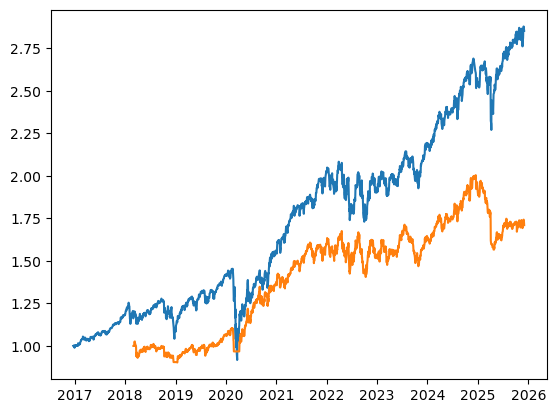

In [85]:
mv_wealth = mv_res["wealth"]
common_index = mv_wealth.index[start_idx_port:]
mv_wealth = mv_wealth.loc[common_index].squeeze()
bh_wealth = bh_res["wealth"].loc[common_index].squeeze()

plt.plot(bh_wealth)
plt.plot(mv_wealth)
plt.show()

In [86]:
def portfolio_metrics(returns, risk_free=0.0, freq=12):
    
    r = np.array(returns)

    # --- 1. 累積リターン ---
    total_return = np.prod(1 + r) - 1

    # --- 2. 年率リターン（幾何平均） ---
    n = len(r)
    annual_return = (1 + total_return) ** (freq / n) - 1

    # --- 3. 年率ボラティリティ ---
    annual_vol = np.std(r, ddof=1) * np.sqrt(freq)

    # --- 4. シャープレシオ ---
    excess_r = r - risk_free
    sharpe = np.mean(excess_r) / np.std(r, ddof=1) * np.sqrt(freq)

    # --- 5. 最大ドローダウン（DD） ---
    wealth = (1 + r).cumprod()
    peak = np.maximum.accumulate(wealth)
    drawdown = wealth / peak - 1
    max_dd = drawdown.min()

    return {
        "total_return": total_return,
        "annual_return": annual_return,
        "annual_vol": annual_vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
    }

In [87]:
portfolio_metrics(bh_res["port_ret"])

{'total_return': 1.854157368265533,
 'annual_return': 0.003881110071928484,
 'annual_vol': 0.03204816806210681,
 'sharpe': 0.1369795266245782,
 'max_drawdown': -0.3690663211763575}

In [88]:
portfolio_metrics(mv_res["port_ret"])

{'total_return': nan,
 'annual_return': nan,
 'annual_vol': nan,
 'sharpe': nan,
 'max_drawdown': nan}

In [89]:
def build_macro_features(rets):
    # --------------------------
    # 1) 日付レンジを揃える
    # --------------------------
    start_date = rets.index[0].strftime("%Y-%m-%d")
    end_date = rets.index[-1].strftime("%Y-%m-%d")
    
    # 日付を business day ベースで reindex（マーケット営業日に揃える）
    idx = rets.index  # あなたの returns の日付
    
    # --------------------------
    # 5) VIX Index (yfinance: ^VIX)
    #    - Log-difference and EWMA(hl=63)
    # --------------------------
    vix = yf.download("^VIX", start=start_date, end=end_date)["Close"]
    vix.name = "VIX"
    vix = vix.reindex(idx).ffill()
    
    vix_logdiff = np.log(vix).diff()
    vix_logdiff_ewm63 = vix_logdiff.ewm(halflife=63, adjust=False).mean()
    
    # --------------------------
    # 6) Stock-Bond Correlation
    #    - S&P500 vs US Agg Bond (1年ローリング)
    # --------------------------
    # S&P500 と AGG の価格を取得
    prices_sb = yf.download(["^GSPC", "AGG"], start=start_date, end=end_date)["Close"]
    prices_sb = prices_sb.reindex(idx).ffill()
    
    spx = prices_sb["^GSPC"]
    agg = prices_sb["AGG"]
    
    # ログリターン
    ret_spx = np.log(spx).diff()
    ret_agg = np.log(agg).diff()
    
    # 1年=252営業日としてローリング相関
    stock_bond_corr = ret_spx.rolling(window=252).corr(ret_agg)
    
    # --------------------------
    # 7) まとめて DataFrame にする
    # --------------------------
    macro_df = pd.DataFrame(index=idx)
    
    # Table3 の項目に対応する列名で作成
    macro_df["vix_logdiff_ewm63"] = vix_logdiff_ewm63      # VIX log-diff EWMA(63)
    macro_df["stock_bond_corr_1y"] = stock_bond_corr       # Rolling 1Y corr
    
    # 初期の NaN は 0 などに埋めてもよい（XGBoost は多少の欠損にも耐えますが）
    macro_df = macro_df.fillna(0.0)
    
    return macro_df


In [90]:
ex = build_macro_features(rets)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


XLB


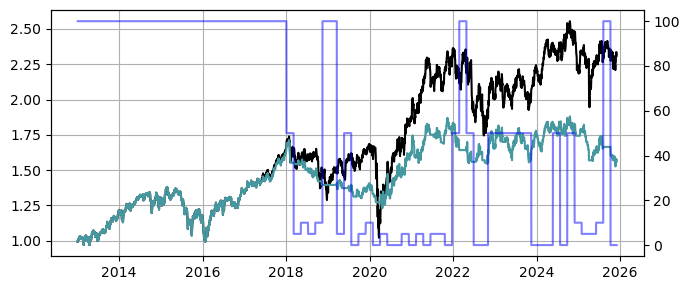

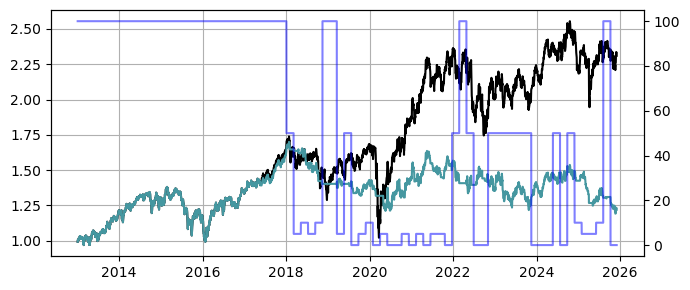

Baseline  Sharpe=0.186, MaxDD=-0.282
Extended  Sharpe=-0.014, MaxDD=-0.299
XLE


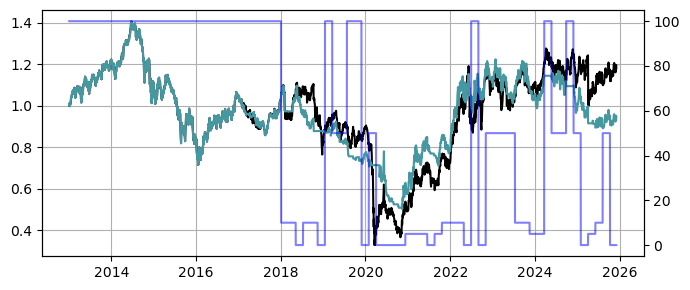

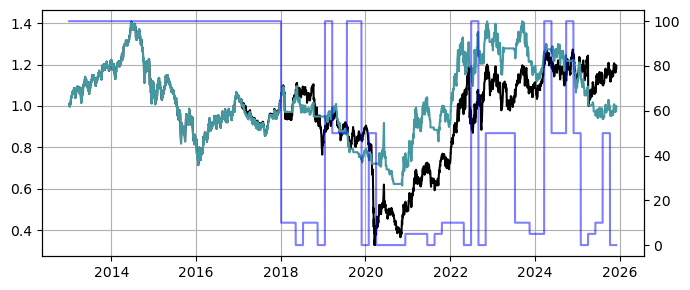

Baseline  Sharpe=0.041, MaxDD=-0.542
Extended  Sharpe=0.072, MaxDD=-0.438
XLF


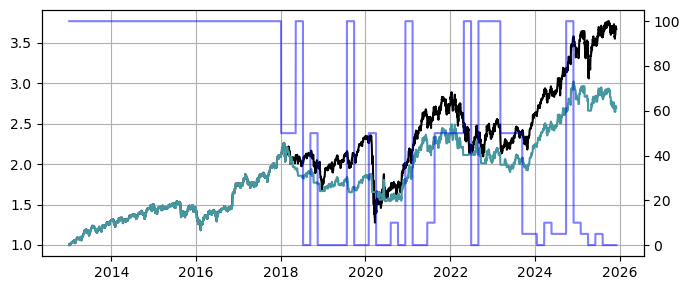

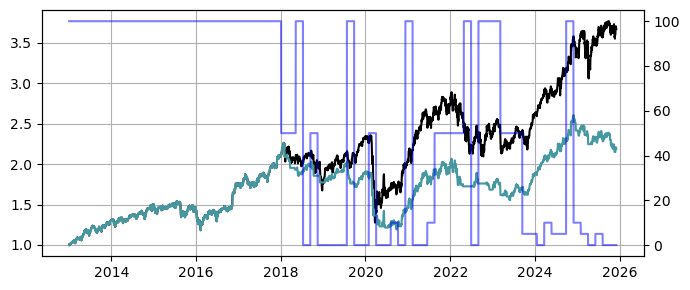

Baseline  Sharpe=0.389, MaxDD=-0.319
Extended  Sharpe=0.234, MaxDD=-0.473
XLI


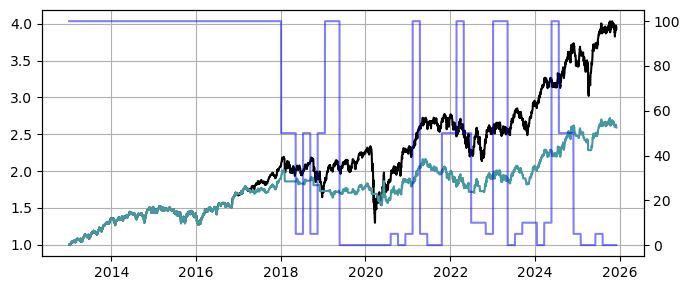

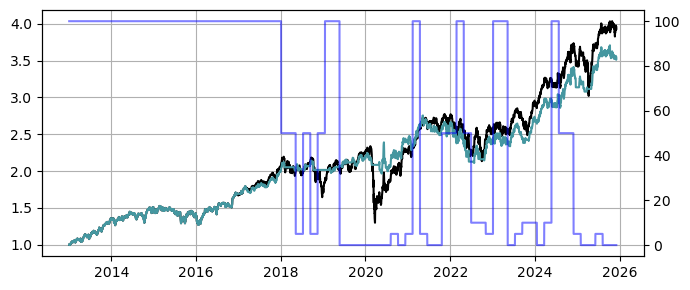

Baseline  Sharpe=0.426, MaxDD=-0.240
Extended  Sharpe=0.698, MaxDD=-0.234
XLK


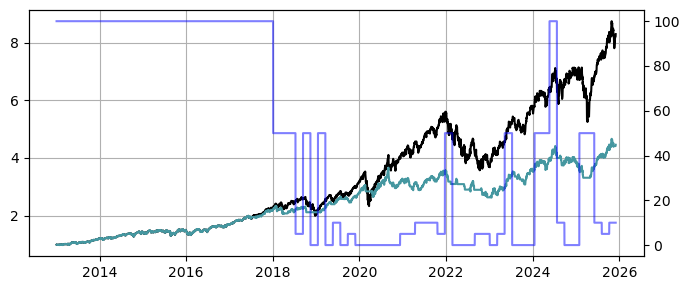

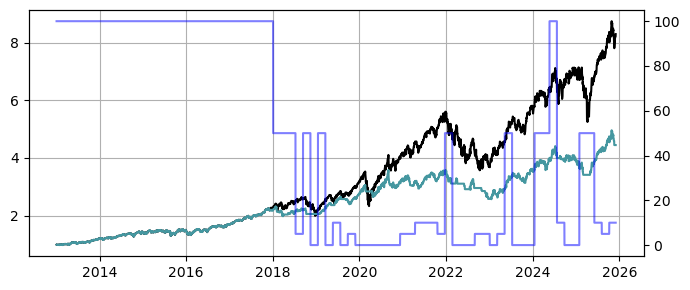

Baseline  Sharpe=0.756, MaxDD=-0.284
Extended  Sharpe=0.758, MaxDD=-0.283
XLP


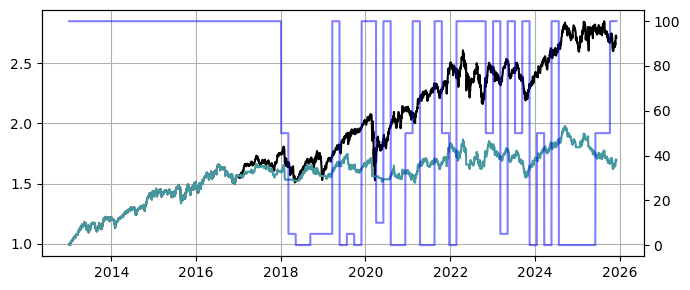

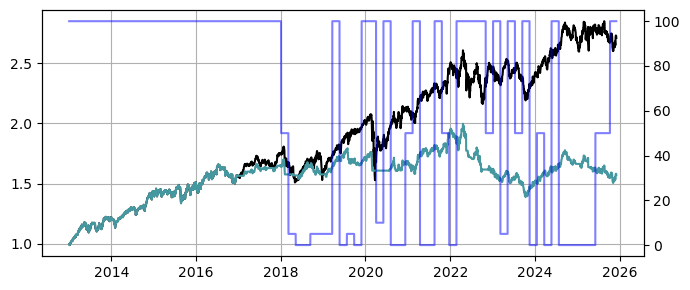

Baseline  Sharpe=0.134, MaxDD=-0.180
Extended  Sharpe=0.054, MaxDD=-0.304
XLU


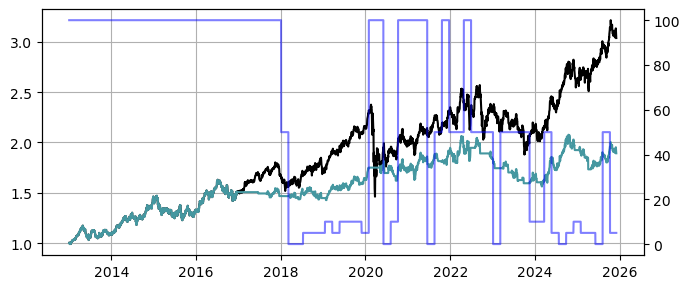

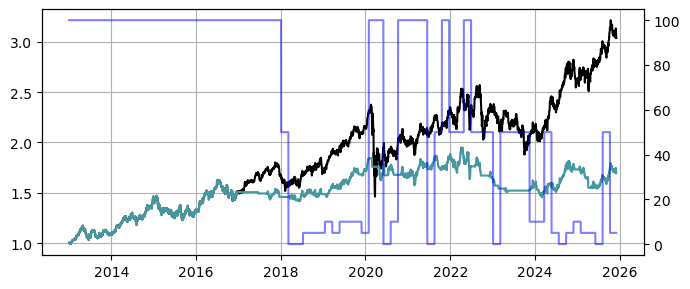

Baseline  Sharpe=0.274, MaxDD=-0.243
Extended  Sharpe=0.171, MaxDD=-0.254
XLV


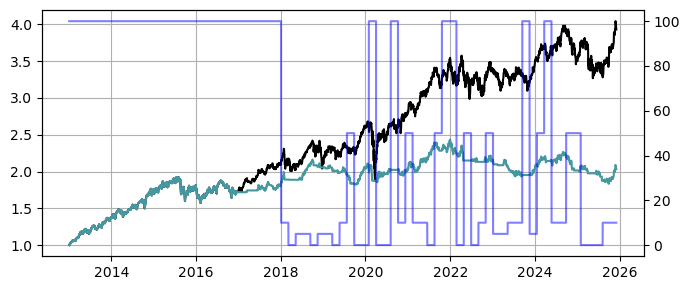

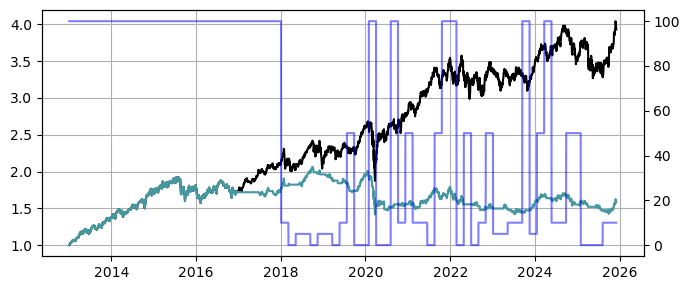

Baseline  Sharpe=0.247, MaxDD=-0.246
Extended  Sharpe=-0.025, MaxDD=-0.313
XLY


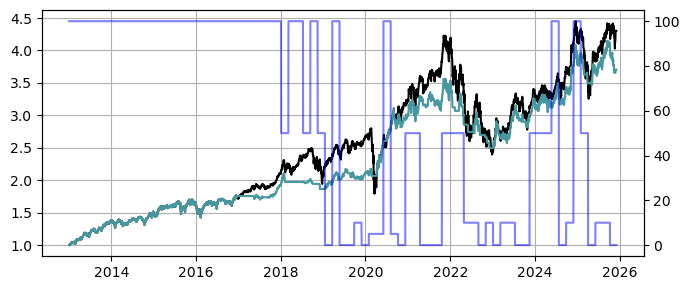

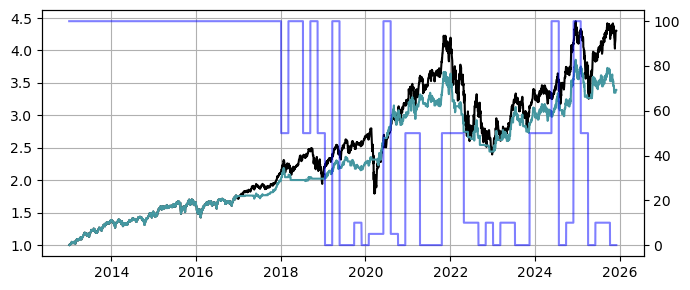

Baseline  Sharpe=0.654, MaxDD=-0.299
Extended  Sharpe=0.593, MaxDD=-0.334


In [91]:
def compute_strategy_returns(rets_series, w_series, start_idx):
    """
    rets_series: 単一資産の日次リターン (Series)
    w_series: run_with_online_lambda の out["w"] (Series)
              1: risky, 0: cash (ここでは cash リターンを 0 とする)
    start_idx: どこから out-of-sample とみなすか（run の start_idx と同じで OK）

    戻り値: out-of-sample 区間の戦略リターン Series
    """
    # out-of-sample 部分だけに切る
    rets_oos = rets_series.iloc[start_idx+1:]
    w_oos = w_series.iloc[start_idx+1:]
    # 0/1 戦略：レジームが 1 の時だけリスク資産のリターンを取る
    strat_rets = w_oos * rets_oos
    return strat_rets

def sharpe_ratio(daily_rets, risk_free=0.0):
    """
    daily_rets: 日次リターン Series
    risk_free: 年率 rf（ここでは 0 前提でもよい）
    """
    if len(daily_rets) < 2 or daily_rets.std(ddof=1) == 0:
        return np.nan
    excess = daily_rets - risk_free / 252.0
    return np.sqrt(252) * excess.mean() / excess.std(ddof=1)

def max_drawdown(daily_rets):
    wealth = (1 + daily_rets).cumprod()
    peak = wealth.cummax()
    dd = wealth / peak - 1.0
    return dd.min()


assets = rets.columns
asset = assets[0]

start_idx = 1000
n_regimes = 2
init_lambda = 100
lambda_grid = [0, 5, 10.0, 50.0, 100.0]
fit_freq_days = 7 * 4
tscv_freq_days = 21 * 3
tscv_window = 252 * 5

res = {}
res_ex = {}
for asset in assets:
    print(asset)
    out = run_with_online_lambda(
        rets[asset], 
        start_idx, 
        n_regimes, 
        init_lambda,
        lambda_grid, 
        fit_freq_days,
        tscv_freq_days,
        tscv_window,
        tscv=True,
        extra_features=None
    )
    strat_rets_base = compute_strategy_returns(rets[asset], out["w"], start_idx)
    sharpe_base = sharpe_ratio(strat_rets_base)
    mdd_base = max_drawdown(strat_rets_base)
    plot(rets[asset], out["w"].values, out["lambda"].values)
    res[asset] = {
        "out": out,
        "sharpe": sharpe_base,
        "maxdd": mdd_base
    }

    out_ex = run_with_online_lambda(
        rets[asset], 
        start_idx, 
        n_regimes, 
        init_lambda,
        lambda_grid, 
        fit_freq_days,
        tscv_freq_days,
        tscv_window,
        tscv=True,
        extra_features=ex
    )
    strat_rets_ext = compute_strategy_returns(rets[asset], out_ex["w"], start_idx)
    sharpe_ext = sharpe_ratio(strat_rets_ext)
    mdd_ext = max_drawdown(strat_rets_ext)
    plot(rets[asset], out_ex["w"].values, out_ex["lambda"].values)
    res_ex[asset] = {
        "out": out_ex,
        "sharpe": sharpe_ext,
        "maxdd": mdd_ext
    }
    
    print(f"Baseline  Sharpe={sharpe_base:.3f}, MaxDD={mdd_base:.3f}")
    print(f"Extended  Sharpe={sharpe_ext:.3f}, MaxDD={mdd_ext:.3f}")
